### Dimensionality Reduction Review
#### Feature selection
##### 07Dec18
Using proportional downsampling techniques, get subsets of discrete and continous data to feature-select prior to running DR algorithms for comparison on relatively low-dimensional raw data.

In [1]:
from fcc_utils import *
from fcc_DRs import *

Using TensorFlow backend.


In [98]:
# reload functions when editing file
import sys
del sys.modules['fcc_DRs']
from fcc_DRs import *

In [2]:
retina_1 = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.digital_expression.txt.gz', cells_axis=1) # cells are columns in this raw datafile

In [3]:
retina_1.data.shape # see how many (cells, features) we are working with

(6600, 20478)

---
#### 0. perform 100-component PCA on arcsinh-transformed raw data

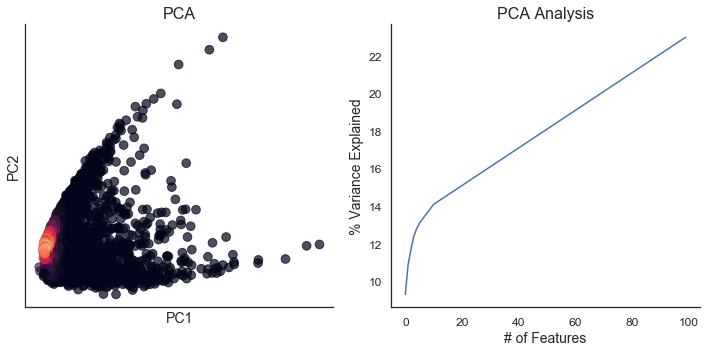

CPU times: user 29.5 s, sys: 4.43 s, total: 34 s
Wall time: 25.1 s


In [4]:
%%time
retina_1_PCA = fcc_PCA(retina_1.arcsinh_norm(), n_components=100)
retina_1_PCA.plot()

---
#### 1. perform t-SNE (perplexity 30) on PCA results and define clusters

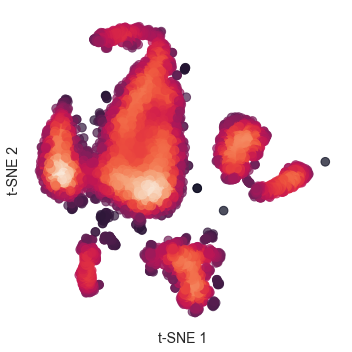

CPU times: user 54 s, sys: 1.99 s, total: 55.9 s
Wall time: 56 s


In [5]:
%%time
retina_1_tSNE = fcc_tSNE(retina_1_PCA.results, perplexity=30)
retina_1_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128499a58>)

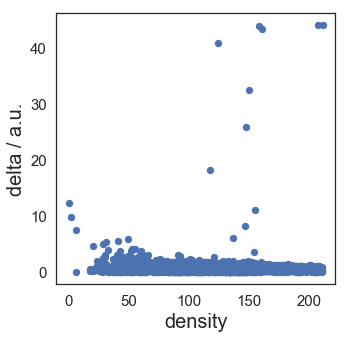

In [6]:
retina_1_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126152438>)

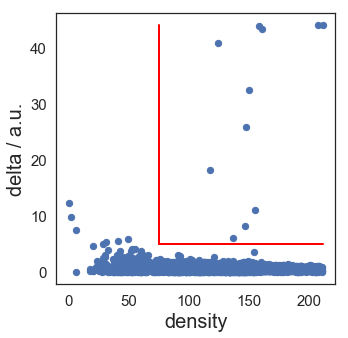

In [7]:
retina_1_tSNE.clu.assign(75, 5)
retina_1_tSNE.clu.draw_decision_graph(min_delta=retina_1_tSNE.clu.min_delta, min_density=retina_1_tSNE.clu.min_density)

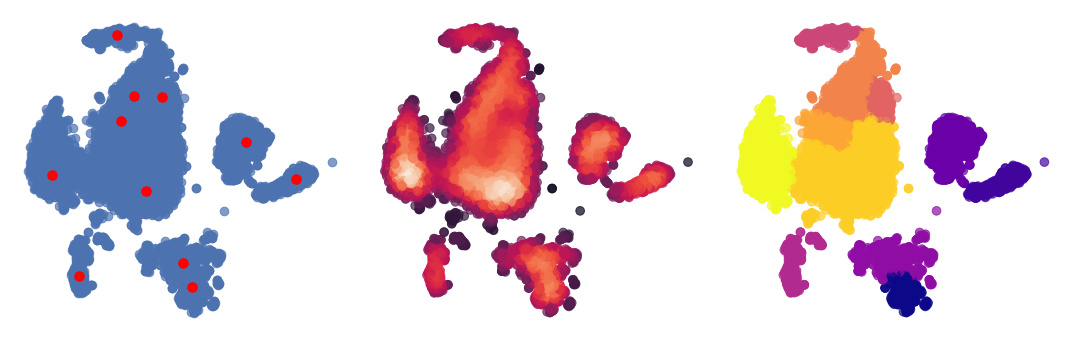

In [8]:
# visualize clustering
retina_1_tSNE.plot_clusters()

In [9]:
retina_1_tSNE.silhouette_score

0.37272608

---
#### 2. downsample dataset proportionally using predefined clusters from t-SNE above

In [10]:
# downsample to total of ~900 cells, maintaining cluster proportions so it (theoretically) clusters the same way when processed
retina_1_reduced = RNA_counts.downsample_proportional(counts_obj=retina_1, clu_membership=retina_1_tSNE.clu.membership, n_cells=900, seed=1)

In [11]:
retina_1_reduced.data.shape # should be slightly more than 900 cells because it rounds up to nearest cell number for each cluster proportion

(905, 20478)

Make sure the porportional downsampling worked by doing the same clustering as before

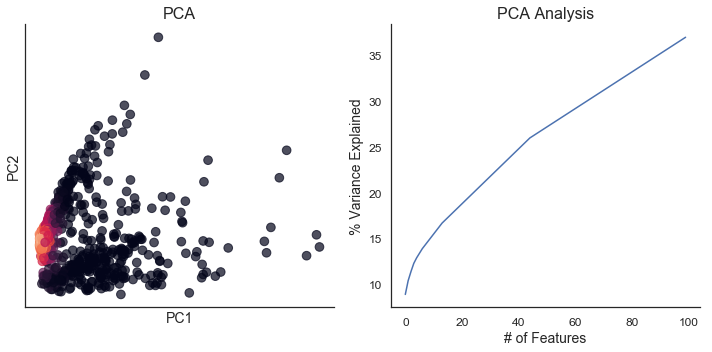

CPU times: user 3.57 s, sys: 590 ms, total: 4.16 s
Wall time: 2.5 s


In [12]:
%%time
retina_1_reduced_PCA = fcc_PCA(retina_1_reduced.arcsinh_norm(), n_components=100)
retina_1_reduced_PCA.plot()

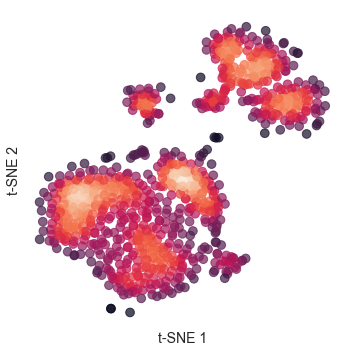

CPU times: user 5.26 s, sys: 74.5 ms, total: 5.34 s
Wall time: 5.17 s


In [13]:
%%time
retina_1_reduced_tSNE = fcc_tSNE(retina_1_reduced_PCA.results, perplexity=30)
retina_1_reduced_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1208f6eb8>)

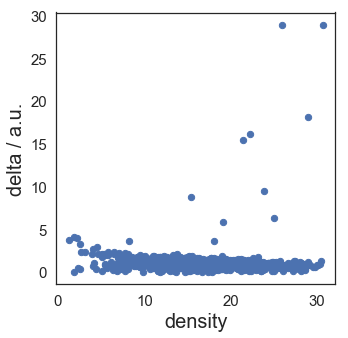

In [14]:
retina_1_reduced_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120a4eeb8>)

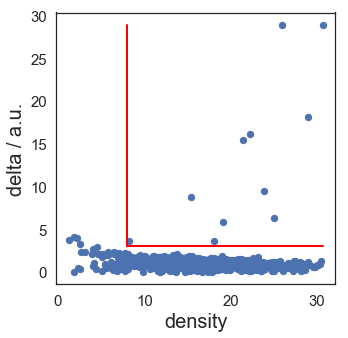

In [15]:
retina_1_reduced_tSNE.clu.assign(8, 3)
retina_1_reduced_tSNE.clu.draw_decision_graph(min_delta=retina_1_reduced_tSNE.clu.min_delta, min_density=retina_1_reduced_tSNE.clu.min_density)

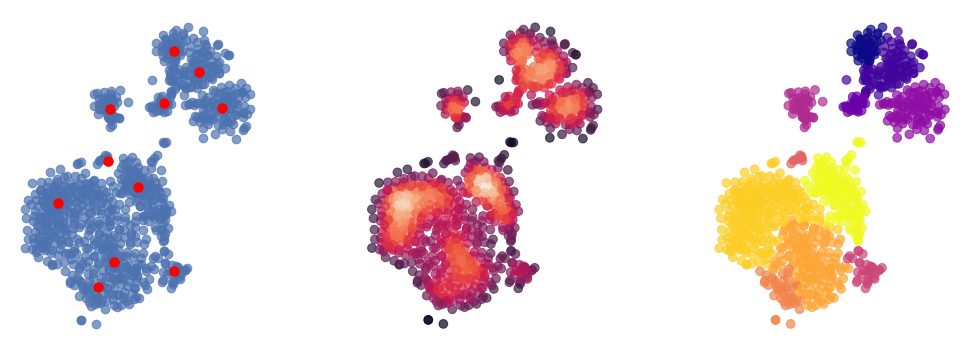

In [16]:
retina_1_reduced_tSNE.plot_clusters()

In [17]:
retina_1_reduced_tSNE.silhouette_score

0.32682654

---
#### 3. perform NVR feature selection on downsampled data

In [18]:
%time retina_1_reduced_nvr = RNA_counts.nvr_select(retina_1_reduced)

Start min_conn_k
2 connections needed
Finished min_conn_k 
Start traj_dist
Finished traj_dist
Start adaptive_knn_graph
Finished adaptive_knn_graph
Start global variance calculation
Finished global variance calculation
Start neighborhood variance calculation
Completion:
Finished neighborhood variance calculation
Start global to neighborhood variance ratio calculation
Finished global to neighborhood variance ratio calculation
Finished selection_val
Finished gene selection in 375.381795167923 seconds
done

Selected 762 variable genes

CPU times: user 6min 12s, sys: 2.31 s, total: 6min 14s
Wall time: 6min 16s


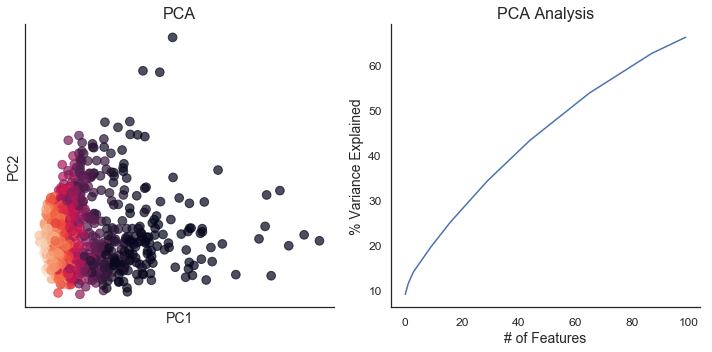

CPU times: user 926 ms, sys: 121 ms, total: 1.05 s
Wall time: 571 ms


In [20]:
%%time
retina_1_reduced_nvr_PCA = fcc_PCA(retina_1_reduced_nvr.arcsinh_norm(), n_components=100)
retina_1_reduced_nvr_PCA.plot()

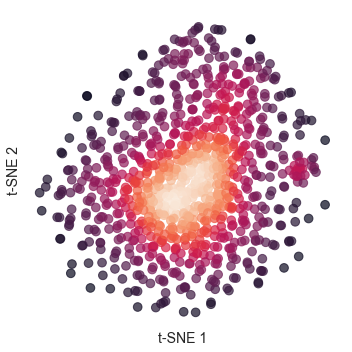

CPU times: user 6.1 s, sys: 169 ms, total: 6.27 s
Wall time: 6.1 s


In [21]:
%%time
retina_1_reduced_nvr_tSNE = fcc_tSNE(retina_1_reduced_nvr_PCA.results, perplexity=30)
retina_1_reduced_nvr_tSNE.plot()

NVR seems to make the resulting data 'lumpy'...  
Need to try another feature selection method

---
#### 3. perform ~~NVR~~ "brute force" feature selection on downsampled data

In [22]:
# let's select the top 500 most variable genes
%time retina_1_reduced_select = RNA_counts.var_select(retina_1_reduced, 500)

CPU times: user 267 ms, sys: 179 ms, total: 445 ms
Wall time: 467 ms


In [23]:
retina_1_reduced_select.data.shape

(905, 500)

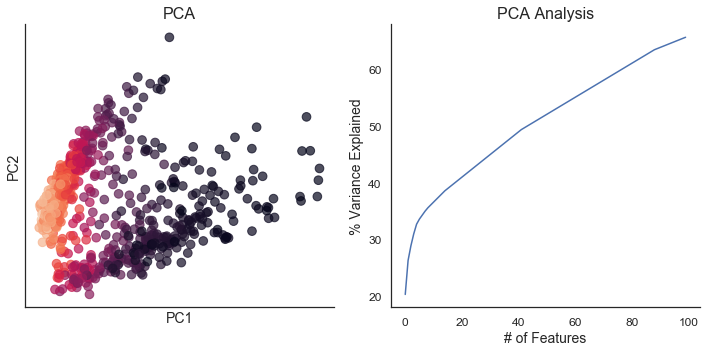

CPU times: user 850 ms, sys: 90.1 ms, total: 940 ms
Wall time: 514 ms


In [24]:
%%time
retina_1_reduced_select_PCA = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=100)
retina_1_reduced_select_PCA.plot()

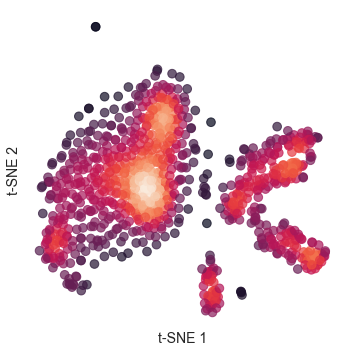

CPU times: user 5.96 s, sys: 151 ms, total: 6.11 s
Wall time: 5.95 s


In [25]:
%%time
retina_1_reduced_select_tSNE = fcc_tSNE(retina_1_reduced_select_PCA.results, perplexity=30)
retina_1_reduced_select_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120d2a240>)

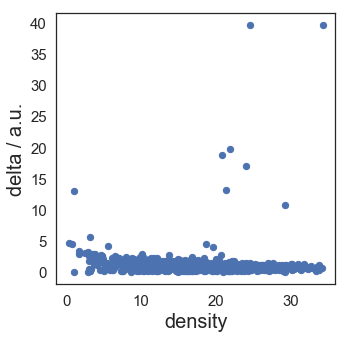

In [26]:
retina_1_reduced_select_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120ab68d0>)

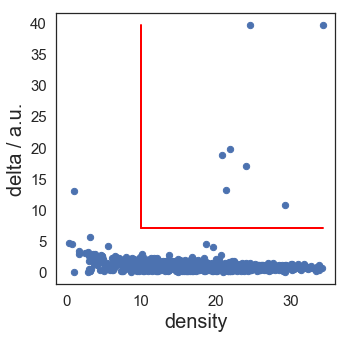

In [27]:
retina_1_reduced_select_tSNE.clu.assign(10,7)
retina_1_reduced_select_tSNE.clu.draw_decision_graph(min_delta=retina_1_reduced_select_tSNE.clu.min_delta, min_density=retina_1_reduced_select_tSNE.clu.min_density)

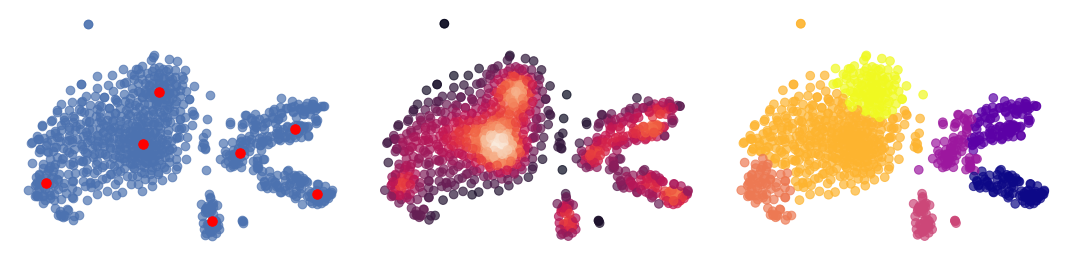

In [28]:
retina_1_reduced_select_tSNE.plot_clusters()

In [29]:
retina_1_reduced_select_tSNE.silhouette_score

0.34756744

So this seems to work better. Let's proceed.

---
#### 4. perform DR techniques on downsampled, feature-selected dataset and compare to original

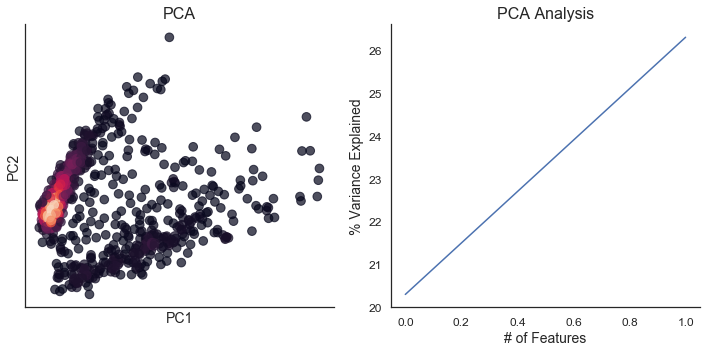

CPU times: user 714 ms, sys: 77.3 ms, total: 791 ms
Wall time: 439 ms


In [30]:
%%time
retina_1_reduced_select_PCA = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=2)
retina_1_reduced_select_PCA.plot()

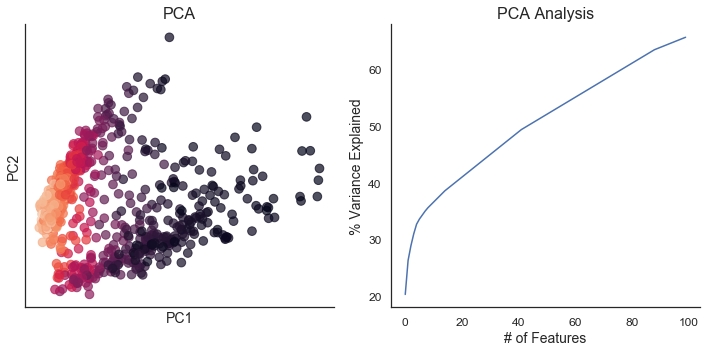

CPU times: user 853 ms, sys: 83.7 ms, total: 936 ms
Wall time: 512 ms


In [31]:
%%time
retina_1_reduced_select_PCA_100 = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=100)
retina_1_reduced_select_PCA_100.plot()

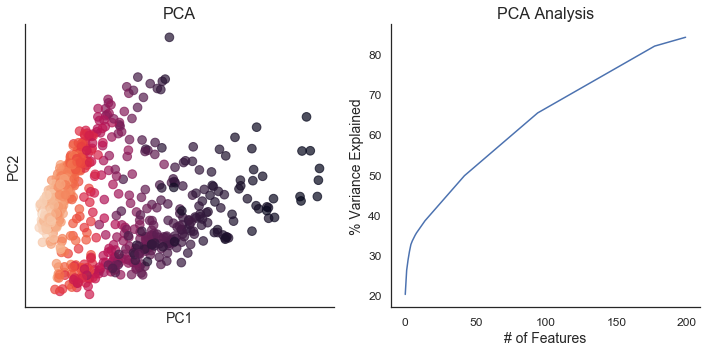

CPU times: user 1.01 s, sys: 111 ms, total: 1.12 s
Wall time: 620 ms


In [32]:
%%time
retina_1_reduced_select_PCA_200 = fcc_PCA(retina_1_reduced_select.arcsinh_norm(), n_components=200)
retina_1_reduced_select_PCA_200.plot()

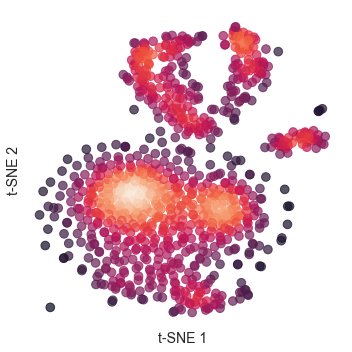

CPU times: user 6.15 s, sys: 290 ms, total: 6.44 s
Wall time: 6.27 s


In [33]:
%%time
retina_1_reduced_select_tSNE = fcc_tSNE(retina_1_reduced_select.arcsinh_norm(), perplexity=30)
retina_1_reduced_select_tSNE.plot()

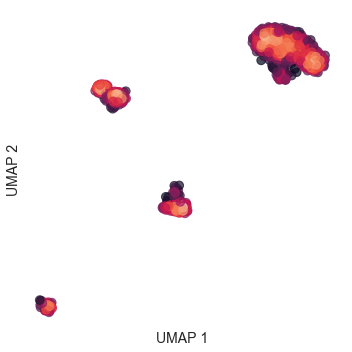

CPU times: user 7.22 s, sys: 200 ms, total: 7.42 s
Wall time: 7.33 s


In [34]:
%%time
retina_1_reduced_select_UMAP = fcc_UMAP(retina_1_reduced_select.arcsinh_norm(), perplexity=30)
retina_1_reduced_select_UMAP.plot()

In [35]:
%time retina_1_reduced_select_DCA = fcc_DCA(retina_1_reduced_select.counts)

DCA: Successfully preprocessed 500 genes and 905 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 15.9 s, sys: 697 ms, total: 16.6 s
Wall time: 9.5 s


##### Now compare the Euclidean distances in all the techniques

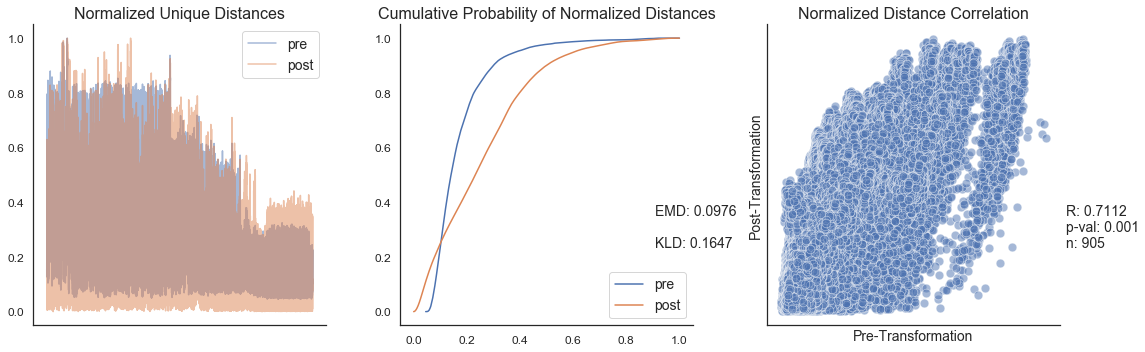

CPU times: user 18.3 s, sys: 2.97 s, total: 21.2 s
Wall time: 20.6 s


((0.7111541625685995, 0.001, 905), 0.09759560669494775, 0.16472474524783084)

In [36]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA.distance_matrix())

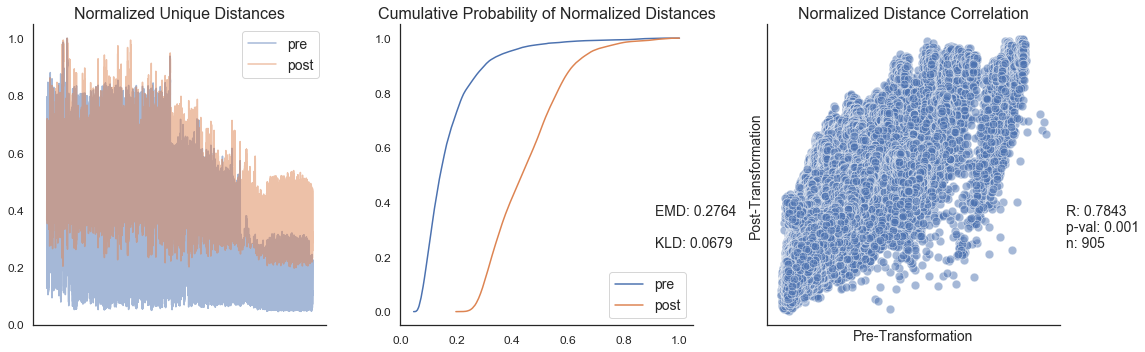

CPU times: user 18.1 s, sys: 2.95 s, total: 21 s
Wall time: 20.4 s


((0.78431385077535, 0.001, 905), 0.2764402617015061, 0.06785084986597312)

In [37]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA_100.distance_matrix())

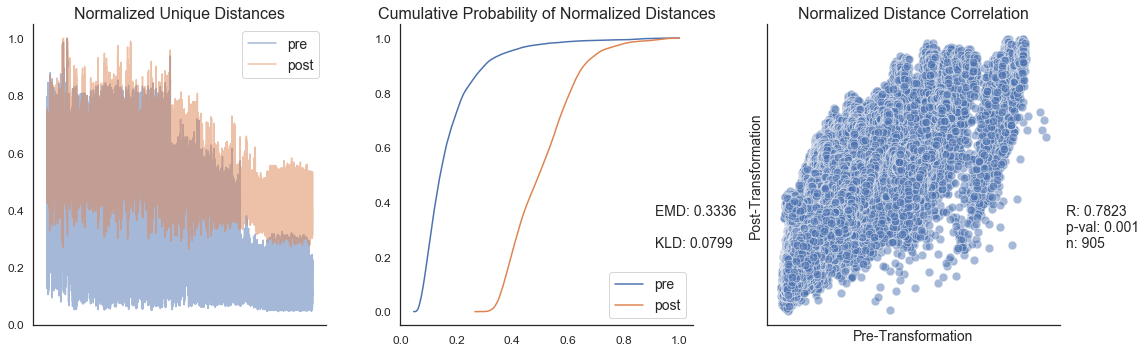

CPU times: user 18 s, sys: 2.78 s, total: 20.8 s
Wall time: 20.1 s


((0.7822981092731137, 0.001, 905), 0.33362283725902053, 0.07988752877067118)

In [38]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_PCA_200.distance_matrix())

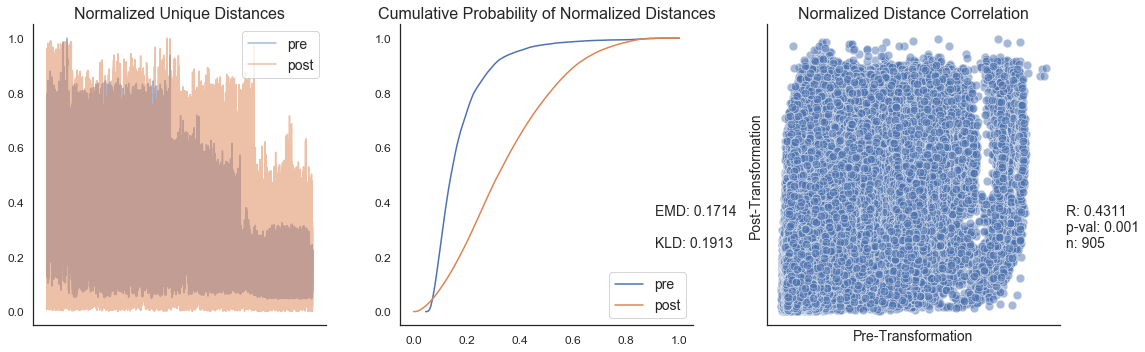

CPU times: user 19.8 s, sys: 2.75 s, total: 22.6 s
Wall time: 21.9 s


((0.4311265332208763, 0.001, 905), 0.17140196501897148, 0.19126072297264243)

In [39]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_tSNE.distance_matrix())

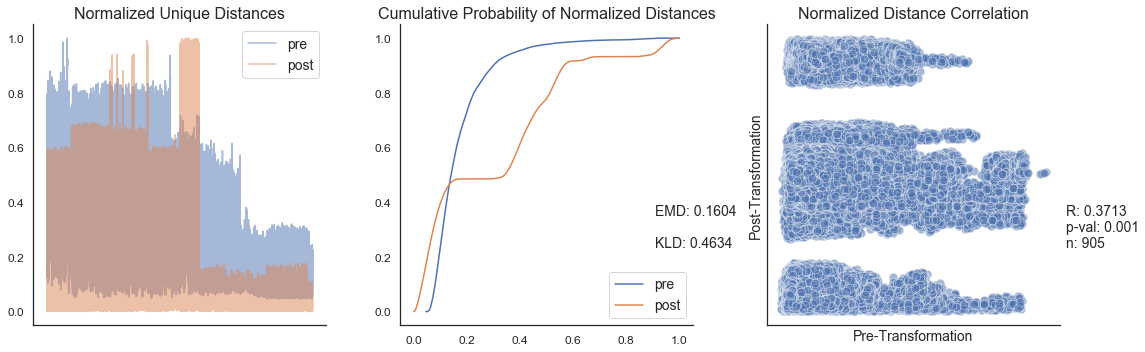

CPU times: user 17.7 s, sys: 2.78 s, total: 20.4 s
Wall time: 19.7 s


((0.3712702440640764, 0.001, 905), 0.1603957215382964, 0.4633708798879697)

In [40]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_UMAP.distance_matrix())

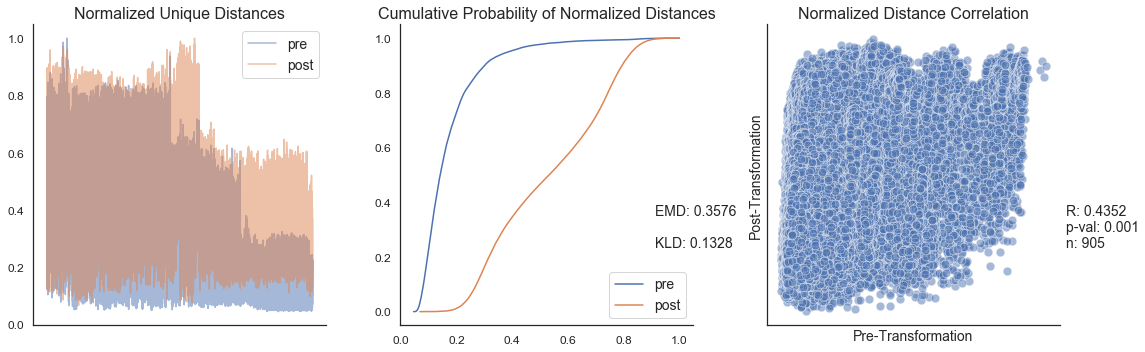

CPU times: user 18.6 s, sys: 2.96 s, total: 21.5 s
Wall time: 21 s


((0.435178691912338, 0.001, 905), 0.35759480700469815, 0.1327612830294859)

In [41]:
%time compare_euclid(pre=retina_1_reduced_select.distance_matrix(), post=retina_1_reduced_select_DCA.distance_matrix())

---
#### 5. Repeat for another dataset

In [44]:
colon1 = RNA_counts.from_file('inputs/GSM2743164_rep1_colon_rnaseq.csv.gz', cells_axis=1)

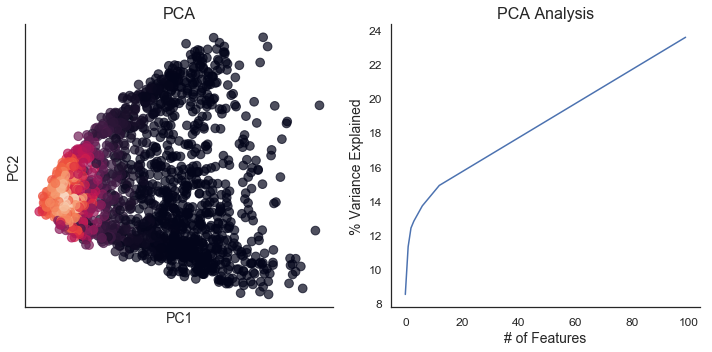

CPU times: user 8.91 s, sys: 1.24 s, total: 10.1 s
Wall time: 6.66 s


In [48]:
%%time
colon1_PCA = fcc_PCA(colon1.arcsinh_norm(), n_components=100)
colon1_PCA.plot()

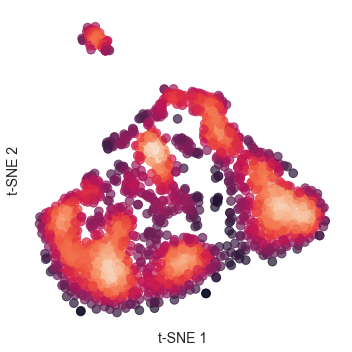

CPU times: user 11.7 s, sys: 413 ms, total: 12.1 s
Wall time: 12 s


In [49]:
%%time
colon1_tSNE = fcc_tSNE(colon1_PCA.results, perplexity=30)
colon1_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128c84d68>)

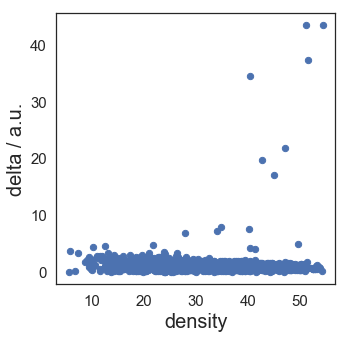

In [50]:
colon1_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12867b2b0>)

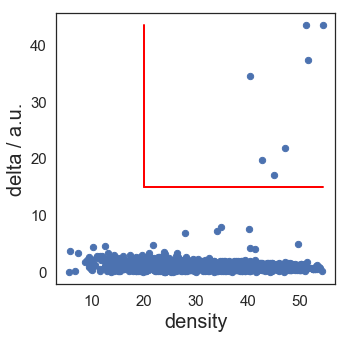

In [51]:
colon1_tSNE.clu.assign(20,15)
colon1_tSNE.clu.draw_decision_graph(min_delta=colon1_tSNE.clu.min_delta, min_density=colon1_tSNE.clu.min_density)

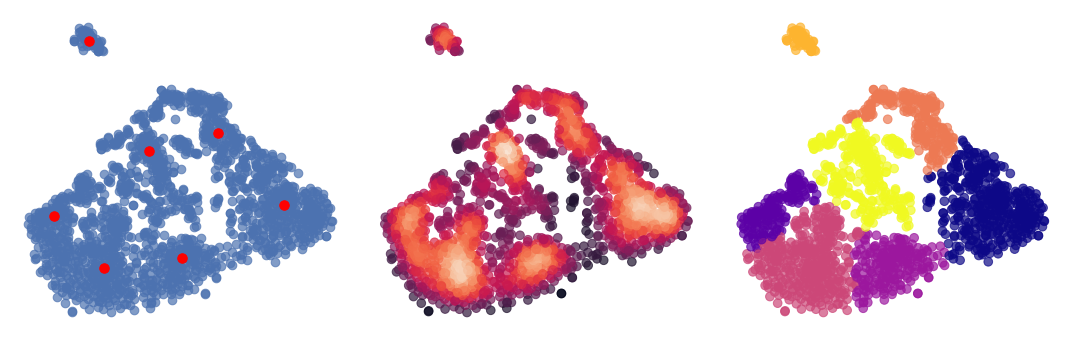

In [52]:
colon1_tSNE.plot_clusters()

In [53]:
colon1_tSNE.silhouette_score

0.43530592

In [54]:
colon1_reduced = RNA_counts.downsample_proportional(counts_obj=colon1, clu_membership=colon1_tSNE.clu.membership, n_cells=900, seed=18)

In [55]:
colon1_reduced_select = RNA_counts.var_select(counts_obj=colon1_reduced, n_features=500)

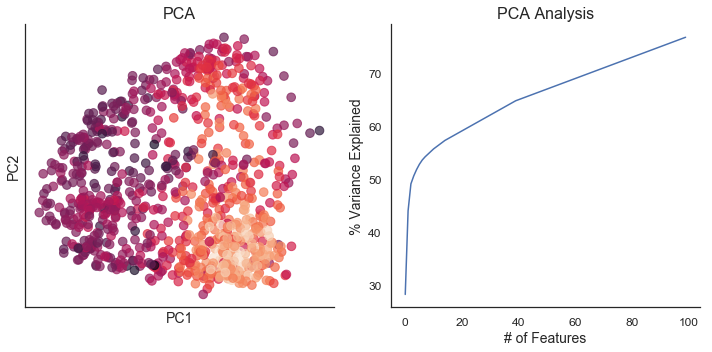

CPU times: user 895 ms, sys: 104 ms, total: 999 ms
Wall time: 552 ms


In [56]:
%%time
colon1_reduced_select_PCA = fcc_PCA(colon1_reduced_select.arcsinh_norm(), n_components=100)
colon1_reduced_select_PCA.plot()

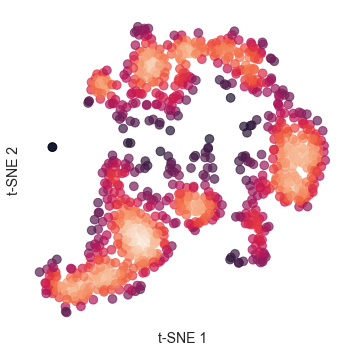

CPU times: user 4.74 s, sys: 98.9 ms, total: 4.84 s
Wall time: 4.67 s


In [57]:
%%time
colon1_reduced_select_tSNE = fcc_tSNE(colon1_reduced_select_PCA.results, perplexity=30)
colon1_reduced_select_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128faba90>)

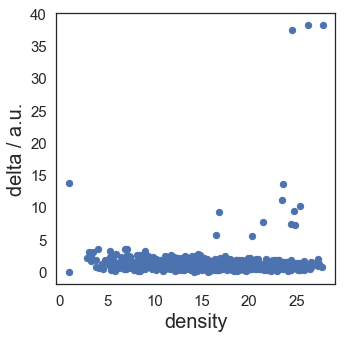

In [58]:
colon1_reduced_select_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12452bcc0>)

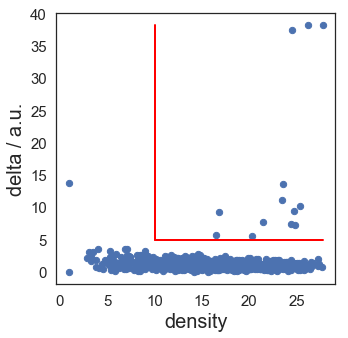

In [59]:
colon1_reduced_select_tSNE.clu.assign(10,5)
colon1_reduced_select_tSNE.clu.draw_decision_graph(min_delta=colon1_reduced_select_tSNE.clu.min_delta, min_density=colon1_reduced_select_tSNE.clu.min_density)

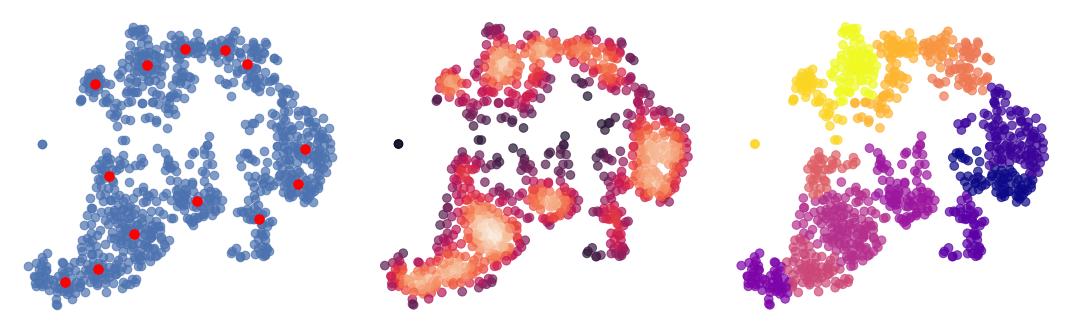

In [60]:
colon1_reduced_select_tSNE.plot_clusters()

In [61]:
colon1_reduced_select_tSNE.silhouette_score

0.37416357

---
#### 6. Repeat for another dataset

In [79]:
AS1 = read_hdf5('inputs/Adj-Norm-1291-AS1.h5')

In [80]:
AS1['counts_0'].shape

(17590, 38254)

In [81]:
AS1 = RNA_counts(AS1['counts_0'], labels=[None,None])

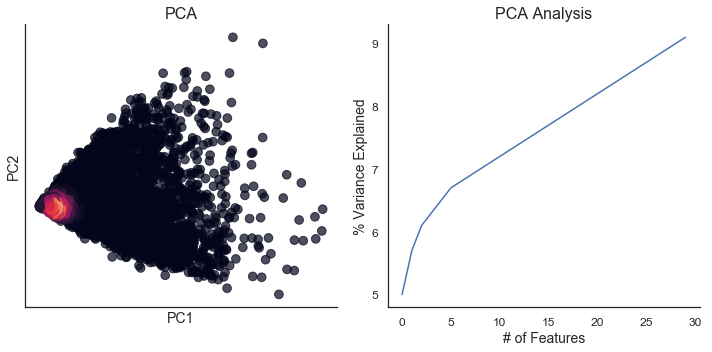

CPU times: user 4min 22s, sys: 4min 18s, total: 8min 41s
Wall time: 12min 28s


In [85]:
%%time
AS1_PCA = fcc_PCA(AS1.arcsinh_norm(), n_components=30) # only 30 components are necessary here
AS1_PCA.plot()

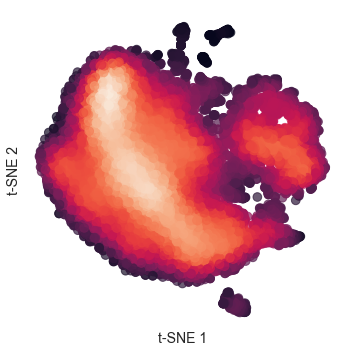

CPU times: user 3min 15s, sys: 11.5 s, total: 3min 26s
Wall time: 3min 37s


In [86]:
%%time
AS1_tSNE = fcc_tSNE(AS1_PCA.results, perplexity=30)
AS1_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1263f3cf8>)

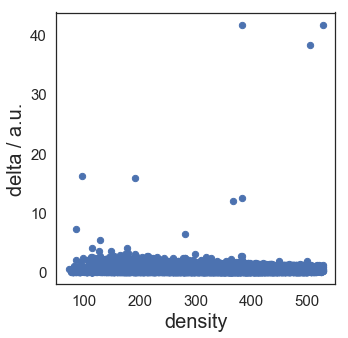

In [87]:
AS1_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120b089e8>)

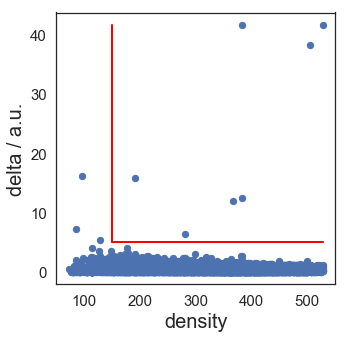

In [88]:
AS1_tSNE.clu.assign(150, 5)
AS1_tSNE.clu.draw_decision_graph(min_delta=AS1_tSNE.clu.min_delta, min_density=AS1_tSNE.clu.min_density)

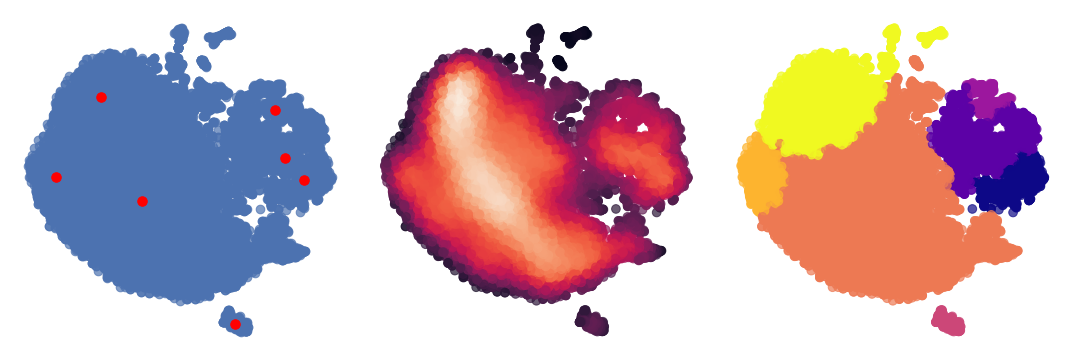

In [89]:
AS1_tSNE.plot_clusters()

In [90]:
AS1_tSNE.silhouette_score

0.10073501

In [101]:
AS1_0 = RNA_counts.downsample_proportional(counts_obj=AS1, clu_membership=AS1_tSNE.clu.membership, n_cells=1000, seed=18)

In [103]:
AS1_0_select = RNA_counts.var_select(counts_obj=AS1_0, n_features=500)

In [104]:
AS1_0_select.data.shape

(1004, 500)

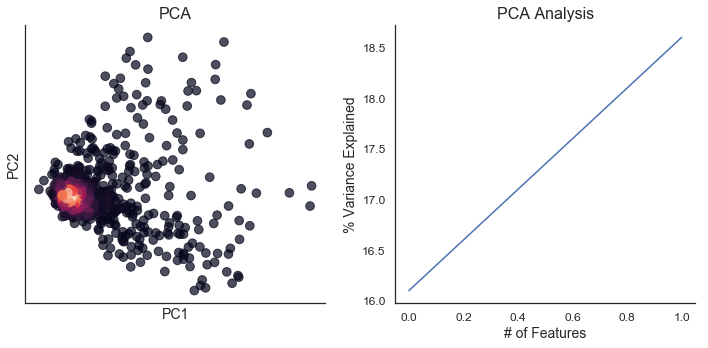

CPU times: user 969 ms, sys: 872 ms, total: 1.84 s
Wall time: 2.45 s


In [111]:
%%time
AS1_0_select_PCA = fcc_PCA(AS1_0_select.arcsinh_norm(), n_components=2)
AS1_0_select_PCA.plot()

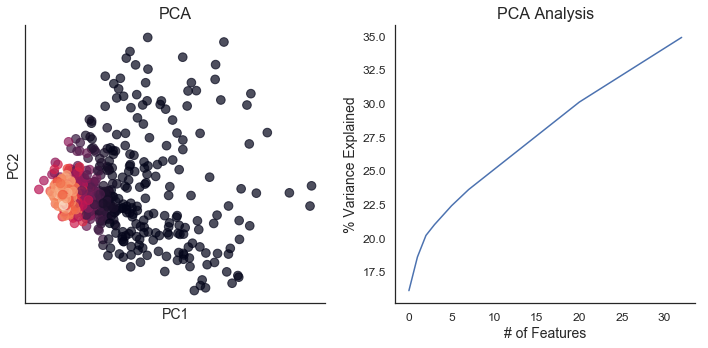

CPU times: user 784 ms, sys: 76.8 ms, total: 860 ms
Wall time: 477 ms


In [116]:
%%time
AS1_0_select_PCA33 = fcc_PCA(AS1_0_select.arcsinh_norm(), n_components=33)
AS1_0_select_PCA33.plot()

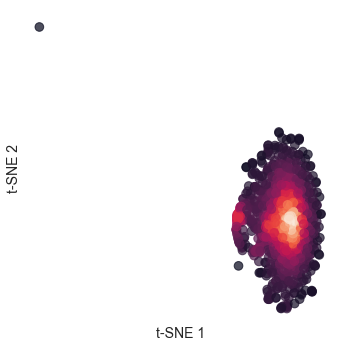

CPU times: user 10.9 s, sys: 313 ms, total: 11.2 s
Wall time: 11.2 s


In [112]:
%%time
AS1_0_select_tSNE = fcc_tSNE(AS1_0_select.arcsinh_norm(), perplexity=30)
AS1_0_select_tSNE.plot()

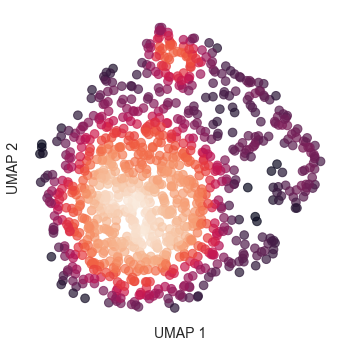

CPU times: user 2.78 s, sys: 194 ms, total: 2.97 s
Wall time: 2.82 s


In [113]:
%%time
AS1_0_select_UMAP = fcc_UMAP(AS1_0_select.arcsinh_norm(), perplexity=30)
AS1_0_select_UMAP.plot()

In [115]:
%%time
AS1_0_select_DCA = fcc_DCA(AS1_0_select.counts)

DCA: Successfully preprocessed 500 genes and 1004 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 19.3 s, sys: 1.07 s, total: 20.4 s
Wall time: 12.8 s


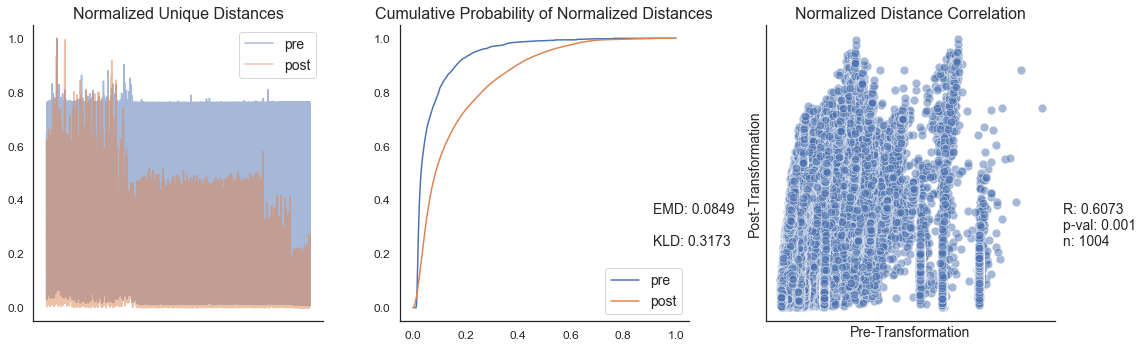

CPU times: user 23.5 s, sys: 3.43 s, total: 26.9 s
Wall time: 26.5 s


In [117]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_PCA.distance_matrix())

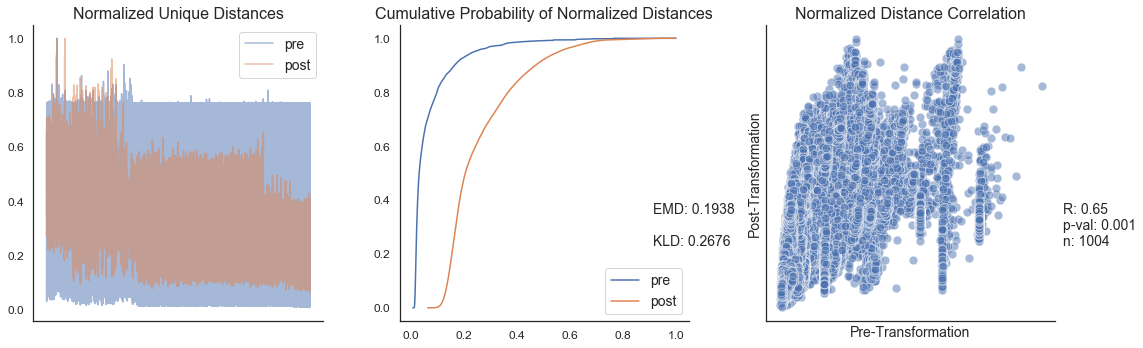

CPU times: user 23.4 s, sys: 3.04 s, total: 26.4 s
Wall time: 26 s


In [118]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_PCA33.distance_matrix())

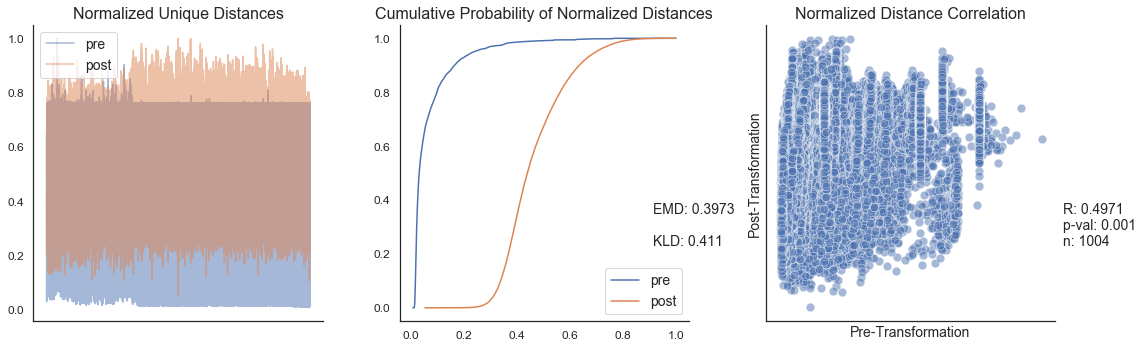

CPU times: user 26.2 s, sys: 3.38 s, total: 29.6 s
Wall time: 29.2 s


In [119]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_DCA.distance_matrix())

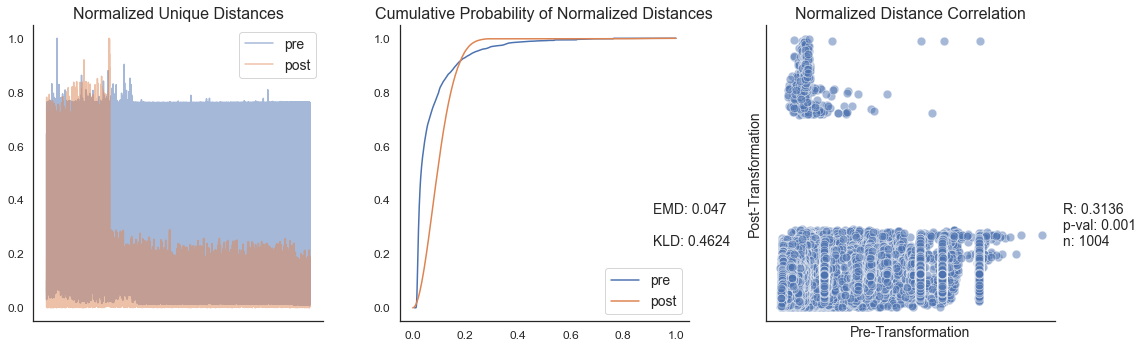

CPU times: user 23.5 s, sys: 3.34 s, total: 26.8 s
Wall time: 26.5 s


In [120]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_tSNE.distance_matrix())

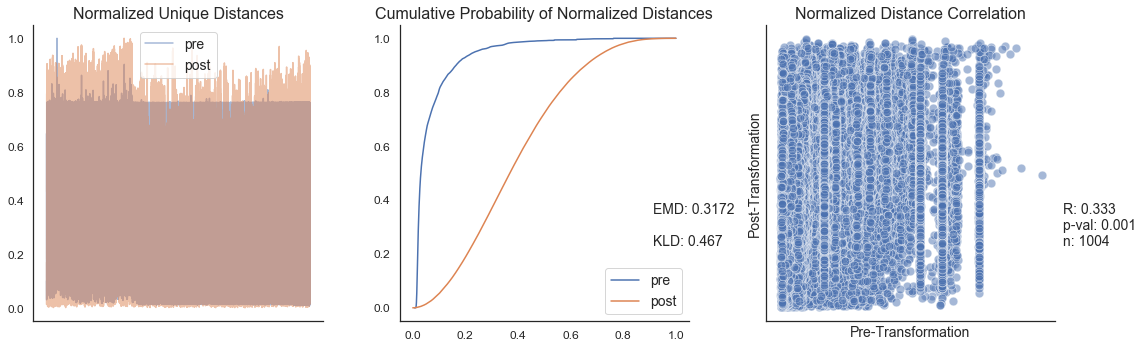

CPU times: user 25.3 s, sys: 3.75 s, total: 29.1 s
Wall time: 28.5 s


In [121]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_select.distance_matrix(), post=AS1_0_select_UMAP.distance_matrix())

---
#### NVR selection on continuous dataset

In [122]:
AS1_0_NVR = RNA_counts.nvr_select(counts_obj=AS1_0, scale=1000)

Start min_conn_k
2 connections needed
Finished min_conn_k 
Start traj_dist
Finished traj_dist
Start adaptive_knn_graph
Finished adaptive_knn_graph
Start global variance calculation
Finished global variance calculation
Start neighborhood variance calculation
Completion:
Finished neighborhood variance calculation
Start global to neighborhood variance ratio calculation
Finished global to neighborhood variance ratio calculation
Finished selection_val
Finished gene selection in 316.38305401802063 seconds
done

Selected 247 variable genes



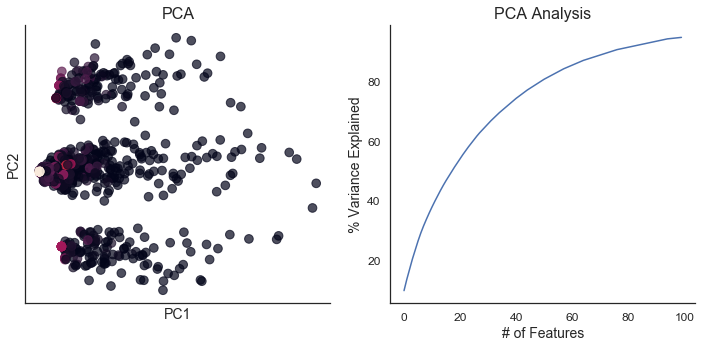

CPU times: user 885 ms, sys: 135 ms, total: 1.02 s
Wall time: 588 ms


In [123]:
%%time
AS1_0_NVR_PCA = fcc_PCA(AS1_0_NVR.arcsinh_norm(), n_components=100)
AS1_0_NVR_PCA.plot()

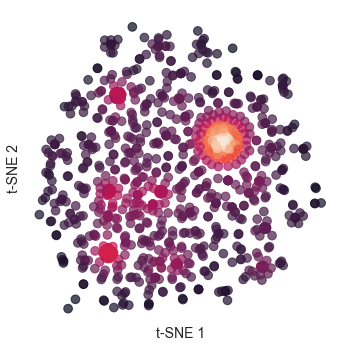

CPU times: user 6.93 s, sys: 295 ms, total: 7.23 s
Wall time: 7.1 s


In [124]:
%%time
AS1_0_NVR_PCAtSNE = fcc_tSNE(AS1_0_NVR_PCA.results, perplexity=30)
AS1_0_NVR_PCAtSNE.plot()

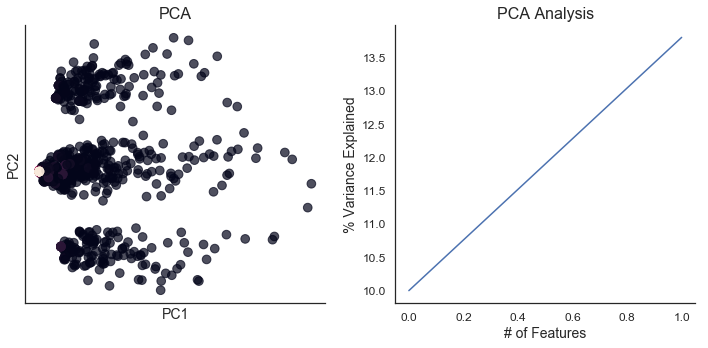

CPU times: user 724 ms, sys: 72.3 ms, total: 796 ms
Wall time: 458 ms


In [125]:
%%time
AS1_0_NVR_PCA = fcc_PCA(AS1_0_NVR.arcsinh_norm(), n_components=2)
AS1_0_NVR_PCA.plot()

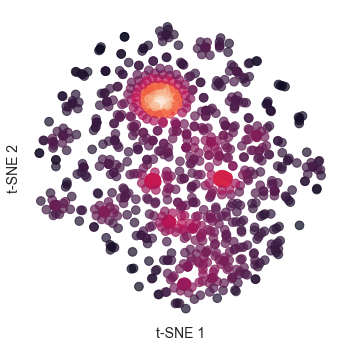

CPU times: user 7.56 s, sys: 338 ms, total: 7.9 s
Wall time: 7.87 s


In [126]:
%%time
AS1_0_NVR_tSNE = fcc_tSNE(AS1_0_NVR.arcsinh_norm(), perplexity=30)
AS1_0_NVR_tSNE.plot()

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/umap/umap_.py:926: RuntimeWarning: invalid value encountered in less
  graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0


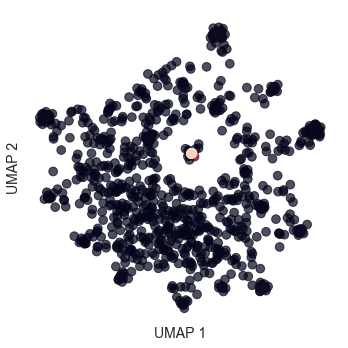

CPU times: user 2.9 s, sys: 204 ms, total: 3.1 s
Wall time: 2.97 s


In [127]:
%%time
AS1_0_NVR_UMAP = fcc_UMAP(AS1_0_NVR.arcsinh_norm(), perplexity=30)
AS1_0_NVR_UMAP.plot()

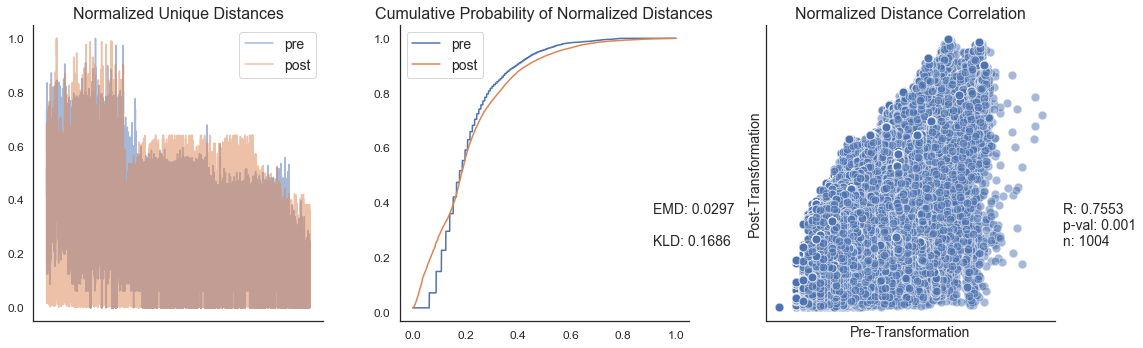

CPU times: user 23 s, sys: 3.31 s, total: 26.3 s
Wall time: 26.2 s


In [128]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_NVR.distance_matrix(), post=AS1_0_NVR_PCA.distance_matrix())

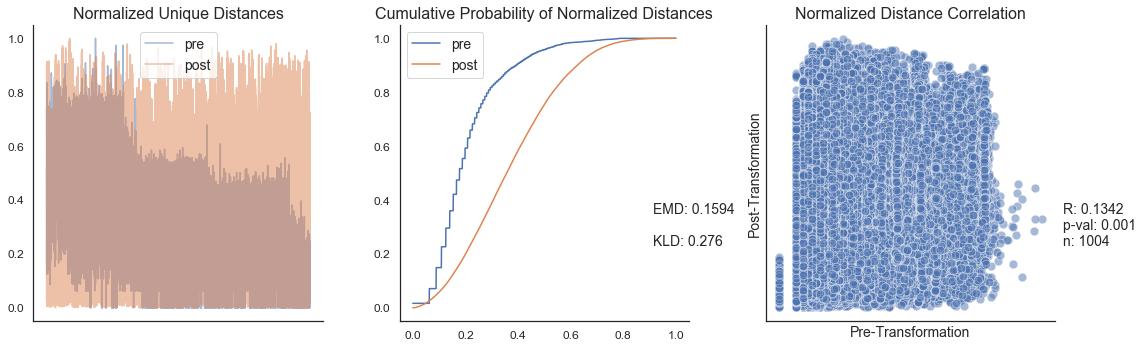

CPU times: user 24.8 s, sys: 4.03 s, total: 28.8 s
Wall time: 28.3 s


In [129]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_NVR.distance_matrix(), post=AS1_0_NVR_tSNE.distance_matrix())

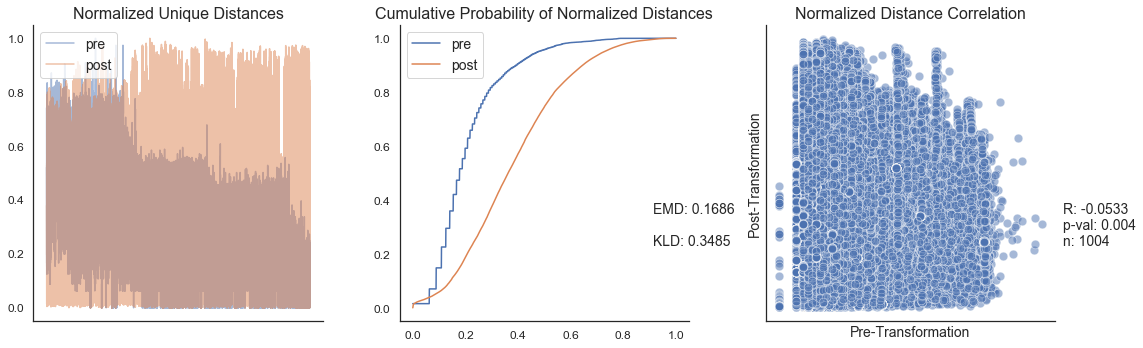

CPU times: user 25.1 s, sys: 3.78 s, total: 28.9 s
Wall time: 28.6 s


In [130]:
%time mantel, EMD, KLD = compare_euclid(pre=AS1_0_NVR.distance_matrix(), post=AS1_0_NVR_UMAP.distance_matrix())